### Disclaimer

Distribution authorized to U.S. Government agencies and their contractors. Other requests for this document shall be referred to the MIT Lincoln Laboratory Technology Office.

This material is based upon work supported by the Under Secretary of Defense for Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions, findings, conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the Under Secretary of Defense for Research and Engineering.

© 2019 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part 252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed above. Use of this work other than as specifically authorized by the U.S. Government may violate any copyrights that exist in this work.


In [1]:
from tesse.msgs import *
from tesse.env import Env

import socket

import time
import matplotlib.pyplot as plt

In [2]:
# port that the simulation is listening on
request_port = 9000
receive_port = 9001

# ip address of the simulation
simulation_ip = "localhost"
own_ip = "localhost"

In [3]:
def plot(data_response):
    imgs = data_response.images
    if( len(imgs) > 1 ):
        fig, ax = plt.subplots(1,len(imgs),figsize=(15,10))
        for i in range(len(imgs)):
            ax[i].axis('off')
            ax[i].imshow(imgs[i])
    else:
        plt.imshow(imgs[0])
        plt.axis('off')

    plt.show()

In [18]:
env = Env(simulation_ip, own_ip, request_port, receive_port)

<TESSE Agent Metadata v0.1>
  <position x='-37.66531/' y='-4.651333' z='41.56885'/>
  <quaternion x='0/' y='0.02195087' z='0' w='0.9997591'/>
  <velocity x_dot='0/' y_dot='0.009163805' z_dot='0'/>
  <angular velocity x_ang_dot='0/' y_ang_dot='0' z_ang_dot ='0'/>
  <acceleration x_ddot='0/' y_ddot='0.4720881' z_ddot='0'/>
  <angular acceleration x_ang_ddot='0/' y_ang_ddot='0' z_ang_ddot='0'/>
  <time>181.1789</time>
  <collision status='false' name=''/>
</TESSE Agent Metadata v0.1>



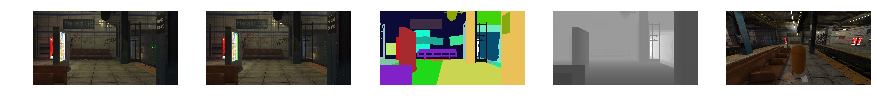

0.3453716897964478


In [20]:
time_diff = 0
n = 100
for i in range(n):
    start = time.time()
    #data_response = env.request(DataRequest(cameras=[(Camera.RGB_LEFT, Compression.OFF, Channels.THREE)
    #                                                 ]))
    data_response = env.request(DataRequest())
    end = time.time()
    time_diff += end - start
print(data_response.data)
plot(data_response)
print(time_diff/n)

In [4]:
class Env22(object):
    def __init__(self, simulation_ip, own_ip, request_port=9000, 
                 receive_port=9000, timeout=15):
        self.simulation_ip = simulation_ip
        self.own_ip = own_ip
        self.request_port = request_port
        self.receive_port = receive_port
        self.send_sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
        self.recv = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        self.recv.settimeout(timeout)
        self.recv.setblocking(1)
        self.recv.bind((self.own_ip, self.receive_port))
        self.recv.listen(1)

    def send(self, msg):
        s = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
        s.sendto(msg.encode(), (self.simulation_ip, self.request_port))
        s.close()

    def request(self, msg):
        # Setup receive socket
        '''
        recv = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        recv.settimeout(timeout)
        recv.setblocking(1)
        recv.bind((self.own_ip, self.receive_port))
        recv.listen(1)
        '''
        request_send_time = time.time()
        # Send request
        self.send(msg)

        # Collect data and construct message
        conn, addr = self.recv.accept()
        print("Round trip time from request to connect accept is {}".format(time.time() - request_send_time))
        #data = bytearray(conn.recv(4))
        data1 = bytearray(12)
        view = memoryview(data1)
        read_bytes = conn.recv_into(view,4)
        view = view[read_bytes:]
        tag = data1[0:4].decode("utf-8")
        read_bytes = conn.recv_into(view,4)
        payload_length_imgs = struct.unpack("I",view[0:4])[0]
        view = view[read_bytes:]
        read_bytes = conn.recv_into(view,4)
        payload_length_meta = struct.unpack("I",view[0:4])[0]
        
        #print(payload_length_imgs)
        #print(payload_length_meta)
        
        data = bytearray(12 + payload_length_imgs + payload_length_meta)
        view = memoryview(data)
        data[:12] = data1
        view = view[12:]
        

        if tag == 'mult':
            img_header_size = 32
            #data.extend(conn.recv(8))
            #payload_length_imgs = struct.unpack("I",data[4:8])[0]
            #data.extend(conn.recv(payload_length_imgs + img_header_size*len(msg.cameras)))
            tot_read_bytes = 0
            start_img_time = time.time()
            while( tot_read_bytes < (payload_length_imgs+payload_length_meta)):
                read_bytes = conn.recv_into(view,(payload_length_imgs+payload_length_meta)-tot_read_bytes)
                tot_read_bytes += read_bytes
                view = view[read_bytes:]
            end_img_time = time.time()
            print("fetch time {}".format(end_img_time - start_img_time))
            #payload_length_meta = struct.unpack("I",data[8:12])[0]
            #data.extend(conn.recv(payload_length_meta))

        elif tag == 'meta' or tag == 'cami' or tag == 'scni':
            #data.extend(conn.recv(4))
            read_bytes = conn.recv_into(view, playload_length_meta)
            #data_length = struct.unpack("I",view[4:8])[0]
            #data = conn.recv(data_length)

        else:
            raise Exception("Unknown tag received: {}.".format(tag))

        #recv.close()
        conn.close()
        
        if tag == 'mult':
            drst = time.time()
            return (DataResponse().decode2(data), drst)
        else:
            return data.decode("utf-8")
        
    def __del__(self):
        self.recv.close()


In [ ]:
env22 = Env22(simulation_ip, own_ip, request_port, receive_port)

In [ ]:
env22.__del__()

Round trip time from request to connect accept is 0.06981158256530762
fetch time 0.021940946578979492
processing message header took 0.0
header parse took 0.0
append op took 0.0
header parse took 0.0
append op took 0.0
header parse took 0.0
append op took 0.0
header parse took 0.0
append op took 0.0
header parse took 0.0
append op took 0.0
time to call decode2 is 0.017290592193603516
total processing time 0.1190176010131836
Round trip time from request to connect accept is 0.08078765869140625
fetch time 0.020943880081176758
processing message header took 0.0
header parse took 0.0
append op took 0.0
header parse took 0.0
append op took 0.0
header parse took 0.0
append op took 0.0
header parse took 0.0
append op took 0.0
header parse took 0.0
append op took 0.0
time to call decode2 is 0.016953706741333008
total processing time 0.13315916061401367
Round trip time from request to connect accept is 0.06383037567138672
fetch time 0.0299222469329834
processing message header took 0.0
header p

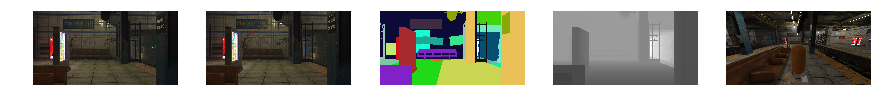

0.12016520500183106


In [23]:
env22 = Env22(simulation_ip, own_ip, request_port, receive_port)
time_diff = 0
n = 10
for i in range(n):
    start = time.time()
    '''
    data_response = env22.request(DataRequest(cameras=[(Camera.RGB_LEFT, Compression.OFF, Channels.SINGLE),
(Camera.RGB_RIGHT, Compression.OFF, Channels.SINGLE),
(Camera.SEGMENTATION, Compression.OFF, Channels.THREE),
(Camera.DEPTH, Compression.OFF, Channels.SINGLE)]))
    '''
    (data_response,drst) = env22.request(DataRequest())
    print("time to call decode2 is {}".format(time.time() - drst))
    end = time.time()
    print("total processing time {}".format(end-start))
    time_diff += end - start
    
print(data_response.data)
plot(data_response)
print(time_diff/n)
env22.__del__()